# Preliminary questions & EDA

- TODO: add notebook description

## Table of contents:

* [1. Data loading](#first-enumeration)
* [2. General statistics](#second-enumeration)
* [3. Answers to questions](#third-enumeration)
  - [a. Which department made the highest turnover in 2016?](#third-enumeration-a)
  - [b. What are the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover over all stores?](#third-enumeration-b)
  - [c. What was the top performer store in 2014?](#third-enumeration-c)
  - [d. Based on sales can you guess what kind of sport represents department 73?](#third-enumeration-d)
  - [e. Based on sales can you guess what kind of sport represents department 117?](#third-enumeration-e)
  - [f. What other insights can you draw from the data? Provide plots and figures if needed. (Optional)](#third-enumeration-f)

In [123]:
import os

from pandasql import sqldf
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import random


import warnings
warnings.filterwarnings('ignore')

## 1. Data loading <a class="anchor" id="first-enumeration"></a>

In [124]:
# Global variable for data relative path
DATA_PATH = os.path.abspath("../data/inputs")

In [125]:
train_data = pd.read_csv(os.path.join(DATA_PATH, "train", "train.csv"))
bu_feat = pd.read_csv(os.path.join(DATA_PATH, "bu_feat.csv"))

#format day_id as datetime type
train_data["day_id"] = pd.to_datetime(train_data["day_id"], infer_datetime_format=True)

## 2. General statistics  <a class="anchor" id="second-enumeration"></a>

We show some general statistics about the data for preliminary exploration

In [126]:
# columns type
print("Columns type : \n{}".format(train_data.dtypes))

Columns type : 
day_id                   datetime64[ns]
but_num_business_unit             int64
dpt_num_department                int64
turnover                        float64
dtype: object


In [127]:
# data shape
print("Train data shape : {} ".format(train_data.shape))

Train data shape : (277719, 4) 


In [128]:
print("NaN Values: \n{}".format(train_data.isna().any()))

NaN Values: 
day_id                   False
but_num_business_unit    False
dpt_num_department       False
turnover                 False
dtype: bool


#### Categorical Features Statistics

In [129]:
train_data.loc[:,train_data.columns != "turnover"].astype("object").describe()

day_id  but_num_business_unit  dpt_num_department
count                277719                 277719              277719
unique                  249                    322                   4
top     2017-09-30 00:00:00                     64                  88
freq                   1270                    996               70230

- We observe that there are 249 dates, 322 business units and 4 departments. Let's dig deeper into these values starting with the days

In [130]:
first_date = train_data["day_id"].min()
last_date = train_data["day_id"].max()

print("First day of measurement : {} ".format(first_date))
print("Last day of measurement : {} ".format(last_date))

First day of measurement : 2012-12-29 00:00:00 
Last day of measurement : 2017-09-30 00:00:00 


In [131]:
print("Number of weeks between the first and the last date is: {:.0f} week".\
      format(((last_date - first_date).days)/7 +1 ))

Number of weeks between the first and the last date is: 249 week


- The number of weeks between the first and last date is equal to the number of unique date values, so there is no gap between dates

In [132]:
print("Number of weekly turnover overall all business units: {}".\
      format(train_data.loc[:, ["day_id", "but_num_business_unit"]].drop_duplicates().shape[0]))

Number of weekly turnover overall all business units: 70743


- The number of weekly takeover overall all business units is less than the total number of combinations (i.e. 322 week * 249 store = 80178). Some business units may not have measurements starting from 2012-12-29. Let's display the 5 newest stores

In [133]:
train_data.loc[:, ["day_id", "but_num_business_unit"]].\
    drop_duplicates().\
    groupby("but_num_business_unit").\
    count().\
    sort_values("day_id").\
    rename(columns= {'day_id' : 'week_count'}).\
    head()

week_count
but_num_business_unit            
1876                           14
1887                           18
1869                           18
1882                           20
1875                           20

Display business units per department

In [134]:
train_data.loc[:, ["dpt_num_department", "but_num_business_unit"]].\
    drop_duplicates().\
    groupby("dpt_num_department").\
    count().\
    sort_values("but_num_business_unit").\
    rename(columns= {'but_num_business_unit' : 'nb_business_units'})

nb_business_units
dpt_num_department                   
117                               315
73                                316
127                               317
88                                322

- Based on the above table, we conclude that some business units do not belong to all departments, except department 88

#### Continuous feature statistics

In [135]:
train_data.loc[:,"turnover"].describe()

count     277719.000000
mean         561.818472
std         2113.229765
min          -69.791165
25%           11.785140
50%          232.724186
75%          676.655825
max      1000000.000000
Name: turnover, dtype: float64

Display turnover statistics by department

In [136]:
train_data.loc[:, ["dpt_num_department", "turnover"]].\
    groupby("dpt_num_department").\
    describe()

turnover                                                   \
                      count         mean          std        min         25%   
dpt_num_department                                                             
73                  68660.0    78.874804   152.395530 -38.361688    2.775478   
88                  70230.0   368.750124  3780.896322  -6.896619  175.832958   
117                 69387.0   426.459506   887.998512 -69.791165    0.660044   
127                 69442.0  1369.834583  1285.382980 -15.390437  571.642851   

                                                              
                            50%          75%             max  
dpt_num_department                                            
73                    21.339732    84.613557     3483.036642  
88                   300.590220   476.785353  1000000.000000  
117                   11.259838   458.215554    14003.878776  
127                 1007.472962  1748.614375    18006.051210

- We notice that department 117 has the highest average turnover and department 73 has the lowest one
- We also notice that there are potentially anomalies in the data, in particular: 1M turnover for department 88, ~14K for department 117 and ~18K for department 127. We can visually identify anomalies using boxplots :

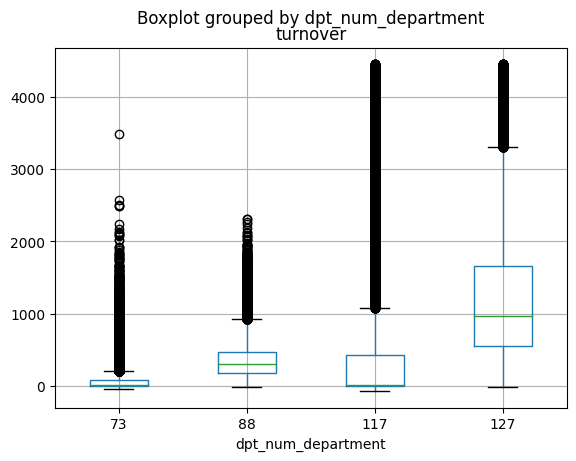

In [137]:
train_data.loc[train_data["turnover"] <= train_data["turnover"].quantile(0.99),["dpt_num_department", "turnover"]].\
    boxplot("turnover", by="dpt_num_department")
plt.show()

#### Display store locations on the map

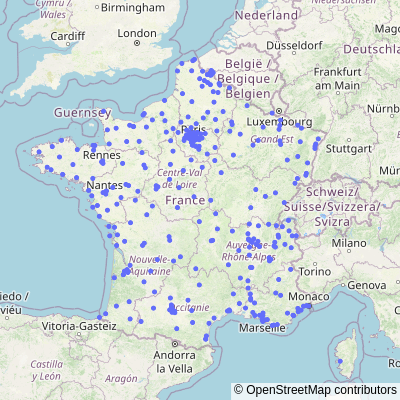

In [138]:
fig = px.scatter_mapbox(bu_feat,
                        lat="but_latitude",
                        lon="but_longitude",
                        hover_name="but_num_business_unit",
                        zoom=4,
                        height=400,
                        width=400)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("png")

## 3. Answers to questions <a class="anchor" id="third-enumeration"></a>

In this section, we will answer the questions provided in the test with two approaches, the sql approach and the pandas internal function approach.

### a.  Which department made the highest turnover in 2016? <a class="anchor" id="third-enumeration-a"></a>

#### SQL query 

In [139]:
# get all variables in the kernel, including train_data and bu_feat
pysqldf = lambda q: sqldf(q, globals())

In [140]:
# define the sql query
query ="""
    SELECT dpt_num_department, MAX(sum_turnover)
    FROM (SELECT dpt_num_department, SUM(turnover) as sum_turnover
          FROM train_data
          WHERE strftime('%Y',day_id) = '2016'
          GROUP BY dpt_num_department)
       """

In [141]:
result = pysqldf(query)

In [142]:
print("The department that achieved the highest turnover in 2016 is:  {} with {:.2E} turnover".\
     format(result.iloc[0]["dpt_num_department"], result.iloc[0]["MAX(sum_turnover)"]))

The department that achieved the highest turnover in 2016 is:  127.0 with 3.38E+07 turnover


#### Pandas style

In [143]:
result = train_data.loc[train_data.day_id.dt.year == 2016, ["dpt_num_department", "turnover"]].\
            groupby("dpt_num_department").\
            sum().\
            sort_values("turnover", ascending=False).\
            head(1)

In [144]:
print("The department that achieved the highest turnover in 2016 is:  {:.0f} with {:.2E} turnover".\
     format(result.index[0], result.iloc[0]["turnover"]))

The department that achieved the highest turnover in 2016 is:  127 with 3.38E+07 turnover


### b. What are the top 5 week numbers (1 to 53) for department 88 in 2015 in terms of turnover over all stores? <a class="anchor" id="third-enumeration-b"></a>


#### SQL query 

In [145]:
query ="""
    SELECT strftime('%W',day_id) as num_week, SUM(turnover) as sum_turnover
    FROM train_data
    WHERE dpt_num_department==88 and  strftime('%Y',day_id) ='2015'
    GROUP BY num_week
    ORDER BY sum_turnover DESC
    LIMIT 5
       """

In [146]:
result = pysqldf(query)
print("The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are :\n {}".\
      format(result))

The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are :
   num_week   sum_turnover
0       26  141679.864768
1       36  139674.400588
2       35  137825.642436
3       37  137232.460861
4       27  125835.541415


- Note that weeks in sqlite ranges from 0 to 52, so add 1 to get the requested range

#### Pandas style

In [147]:
result = train_data.loc[(train_data["day_id"].dt.year == 2015) & (train_data["dpt_num_department"] == 88),\
                       ["day_id", "turnover"]].\
            groupby(train_data["day_id"].dt.isocalendar().week).\
            sum().\
            sort_values("turnover", ascending=False).\
            head()

In [148]:
print("The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are :\n \n {}".\
      format(result))

The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are :
 
            turnover
week               
27    141679.864768
37    139674.400588
36    137825.642436
38    137232.460861
28    125835.541415


### c. What was the top performer store in 2014? <a class="anchor" id="third-enumeration-c"></a>


#### SQL query 

In [149]:
query ="""
    SELECT but_num_business_unit, SUM(turnover) as sum_turnover
    FROM train_data
    WHERE strftime('%Y',day_id) ='2014'
    GROUP BY but_num_business_unit
    ORDER BY sum_turnover DESC
    LIMIT 1
       """

In [150]:
result = pysqldf(query)

In [151]:
print("The top performer store in 2014 is {:.0f} with an overal turnover of {:.2E}".\
        format(result.iloc[0]["but_num_business_unit"], result.iloc[0]["sum_turnover"]))

The top performer store in 2014 is 121 with an overal turnover of 3.28E+05


#### Pandas style

In [152]:
result = train_data.loc[train_data["day_id"].dt.year == 2014, ["turnover"]].\
            groupby(train_data["but_num_business_unit"]).\
            sum().\
            sort_values("turnover", ascending=False).\
            head(1)

In [153]:
print("The top performer store in 2014 is {} with an overal turnover of {:.2E}".\
        format(result.index[0], result.iloc[0]["turnover"]))

The top performer store in 2014 is 121 with an overal turnover of 3.28E+05


### d. Based on sales can you guess what kind of sport represents department 73? <a class="anchor" id="third-enumeration-d"></a>

We will answer this questions with two manners :
- The easiest way is to add up all the department turnovers by store and then display them on a map to see where the stores with the highest turnovers are located.
- The second takes into account the seasonality of the data, a simple approach is to sum up turnovers according to the seasons of the year, then determine the highest season in terms of turnover per store, and finally display results on a map

#### First approach

In [154]:
turnover_by_store = train_data.loc[train_data.dpt_num_department == 73, ["turnover"]].\
                         groupby(train_data["but_num_business_unit"]).\
                         sum()

In [155]:
vis_data = pd.merge(bu_feat, turnover_by_store, on="but_num_business_unit")

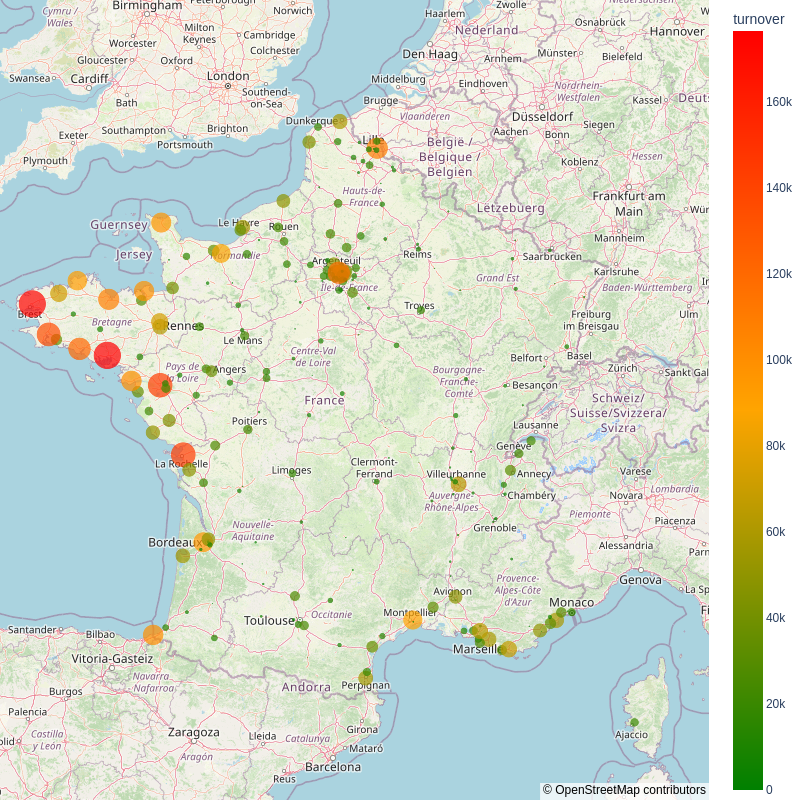

In [156]:
color_scale = [(0, 'green'), (0.5, 'orange'), (1,'red')]

fig = px.scatter_mapbox(vis_data,
                        lat="but_latitude",
                        lon="but_longitude",
                        hover_name="but_num_business_unit",
                        color="turnover",
                        color_continuous_scale=color_scale,
                        size="turnover",
                        zoom=5,
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show("png") # remove "png" argument to get an interactive plot

- **We notice that stores with the highest cumulative turnover are located near the coast. As such, department 73 can be attached to beach sports. We can confirm our hypothesis by displaying the most common weeks with the highest turnover**

In [157]:
# we cumulate the turnover by week number and by store
cum_turnover_by_store_by_week = train_data.loc[train_data.dpt_num_department == 73, ["turnover"]].\
                                   groupby([train_data["but_num_business_unit"], \
                                            train_data["day_id"].dt.isocalendar().week]).\
                                   sum()

In [158]:
# we get the top 5 highest cumulative weekly turnover per store
top_cum_turnover_by_store = cum_turnover_by_store_by_week.\
                                sort_values(["turnover"], ascending=False).\
                                groupby("but_num_business_unit").\
                                head(5)

In [159]:
# finally we get the most common weeks in the top 5 stores
set(top_cum_turnover_by_store.reset_index().head(20).week)

{26, 27, 28, 29, 30, 31, 32, 33}

- These weeks run from the end of June to the end of August, so we can confirm that department 73 is related to beach sports

#### Second approach

In [160]:
# define the 4 seasons of the year based on months
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))

In [161]:
# add up turnovers per season and by store
sum_by_season = train_data.loc[train_data.dpt_num_department == 73, ["turnover"]].\
                    groupby([train_data["but_num_business_unit"],\
                             train_data["day_id"].dt.month.map(month_to_season)]).\
                    sum()

In [162]:
# the highest seasonal turnover by store
top_seasons_by_store = sum_by_season.sort_values(["turnover"], ascending=False).\
                            groupby("but_num_business_unit").\
                            head(1)

In [163]:
# highest seasonal turnover of the top 30 stores
top_season = top_seasons_by_store.reset_index().\
                rename(columns={"day_id" :"season"}).\
                head(30).\
                season.\
                unique()

In [164]:
print("Department 73's best seasonal turnover is: {}".format(top_season[0]))

Department 73's best seasonal turnover is: 3


- Season 3 represents the summer season, and it is the best seasonal turnover of department 73

Let us now display this data on the map, to confirm the result of the first approach

In [165]:
vis_data = pd.merge(bu_feat, top_seasons_by_store, on="but_num_business_unit")

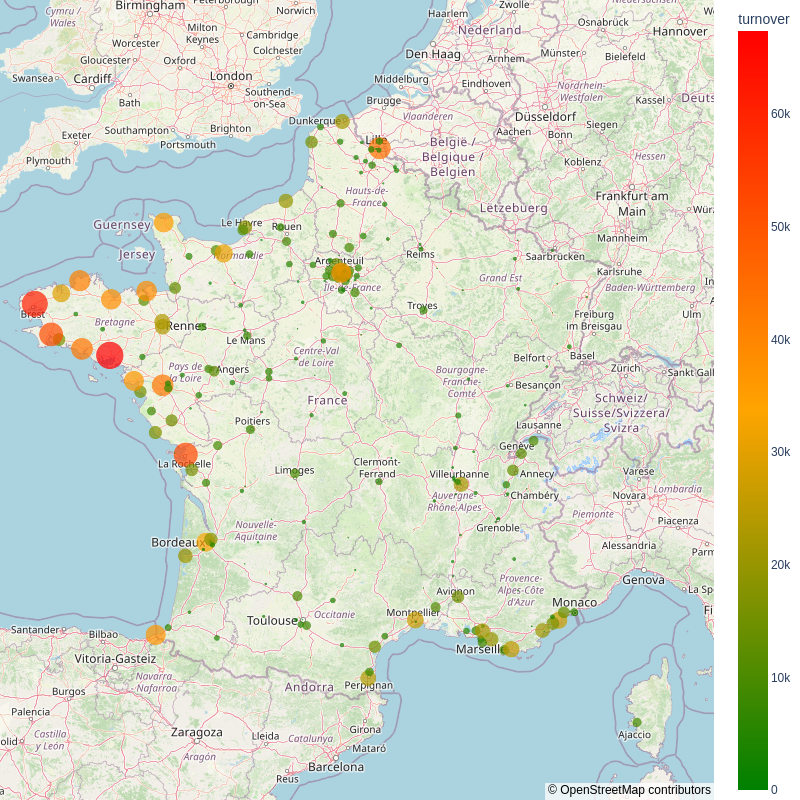

In [166]:
fig = px.scatter_mapbox(vis_data,
                        lat="but_latitude",
                        lon="but_longitude",
                        hover_name="but_num_business_unit",
                        color="turnover",
                        color_continuous_scale=color_scale,
                        size="turnover",
                        zoom=5,
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show("png") # remove "png" argument to get an interactive plot

- We have almost the same map, so we can confirm the conclusion found in the first approach. Department 73 is related to beach sports

### e. Based on sales can you guess what kind of sport represents department 117? <a class="anchor" id="third-enumeration-e"></a>

We will follow the same methodology but with only the second approach (i.e. the seasonal approach)

In [167]:
# add up turnovers per season and by store
sum_by_season = train_data.loc[train_data.dpt_num_department == 117, ["turnover"]].\
                    groupby([train_data["but_num_business_unit"],\
                             train_data["day_id"].dt.month.map(month_to_season)]).\
                    sum()

In [168]:
# the highest seasonal turnover by store
top_seasons_by_store = sum_by_season.sort_values(["turnover"], ascending=False).\
                            groupby("but_num_business_unit").\
                            head(1)

In [169]:
# highest seasonal turnover of the top 30 stores
top_season = top_seasons_by_store.reset_index().\
                rename(columns={"day_id" :"season"}).\
                head(30).\
                season.\
                unique()

In [170]:
print("Department 117's best seasonal turnover is: {}".format(top_season[0]))

Department 117's best seasonal turnover is: 1


- **We can conclude that the winter season is the best sales season in department 117**

We display now the data for this winter season by store on the map, as we did before

In [171]:
vis_data = pd.merge(bu_feat, top_seasons_by_store, on="but_num_business_unit")

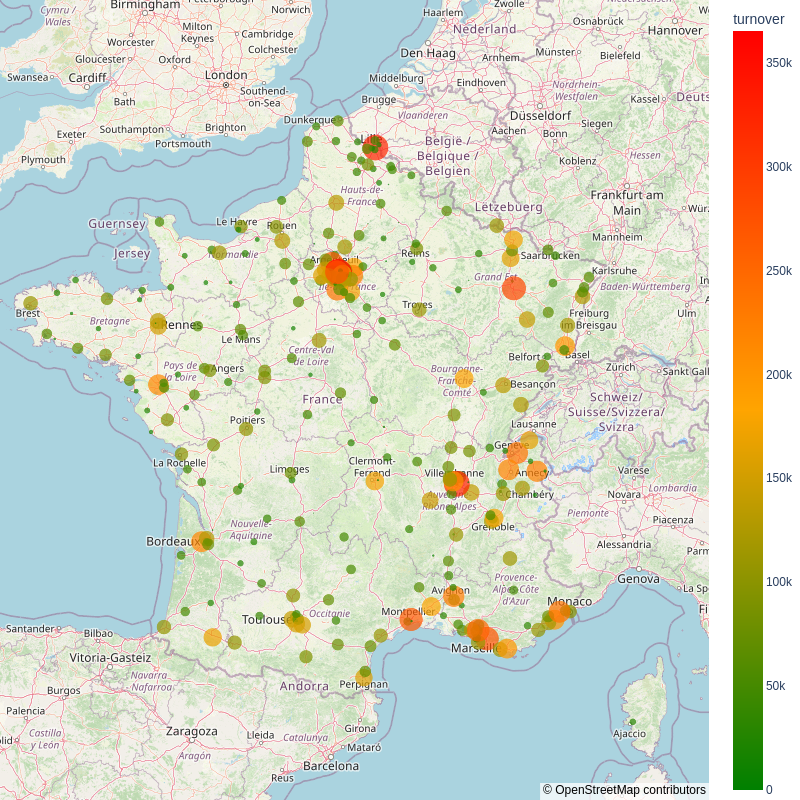

In [172]:
fig = px.scatter_mapbox(vis_data,
                        lat="but_latitude",
                        lon="but_longitude",
                        hover_name="but_num_business_unit",
                        color="turnover",
                        color_continuous_scale=color_scale,
                        size="turnover",
                        zoom=5,
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show("png") # remove "png" argument to get an interactive plot

- We notice that the stores with the best sales are located near the ski resorts. **We can conclude that department 117 is linked to the ski activity**

### f. What other insights can you draw from the data? Provide plots and figures if needed. (Optional) <a class="anchor" id="third-enumeration-f"></a>

Let's do some time series analysis on the data to identify trends, seasonality, pulses (steps) and outliers

TODO: add explanations and comments

#### Plot the aggregate turnover of all stores over the 5 years

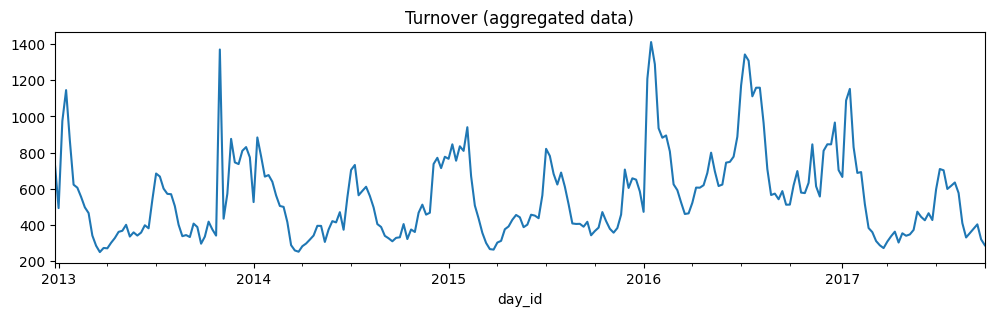

In [173]:
train_data.groupby('day_id').mean()['turnover'].plot(figsize=(12,3), title='Turnover (aggregated data)')
plt.show()

#### Plot the aggregate turnover by department

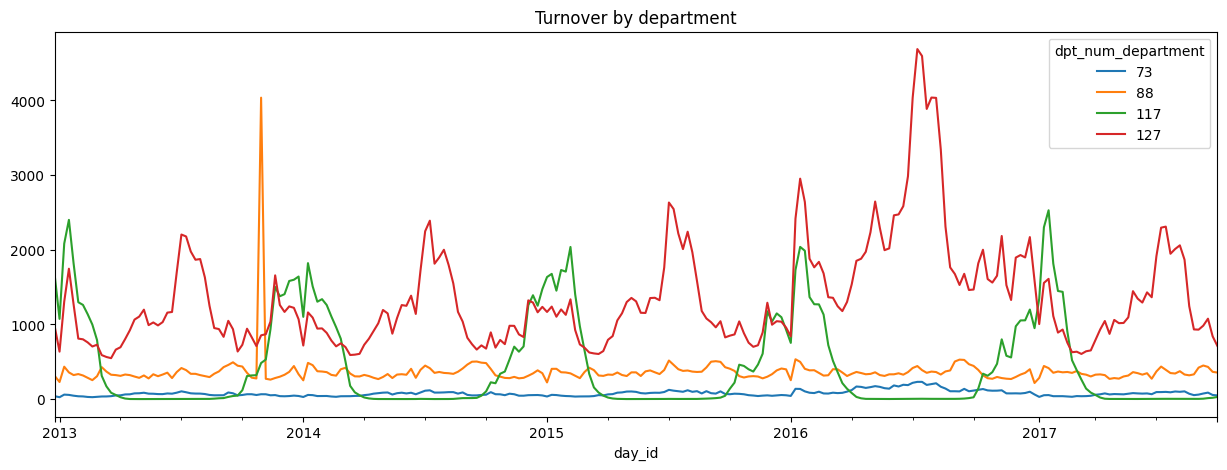

In [174]:
fig, ax  = plt.subplots(1, 1, figsize=(15, 5))
_= pd.pivot_table(train_data, values='turnover', columns="dpt_num_department", index="day_id").\
                  plot(title="Turnover by department", ax=ax)

#### Plot turnover per year

In [175]:
# add year, month, week of year, quarter and season to data
train_data["year"] = train_data.day_id.dt.year
train_data["month"] = train_data.day_id.dt.month
train_data["week"] = train_data.day_id.dt.isocalendar().week
train_data["quarter"] = train_data.day_id.dt.quarter
train_data["season"] = train_data.day_id.dt.month.map(month_to_season)

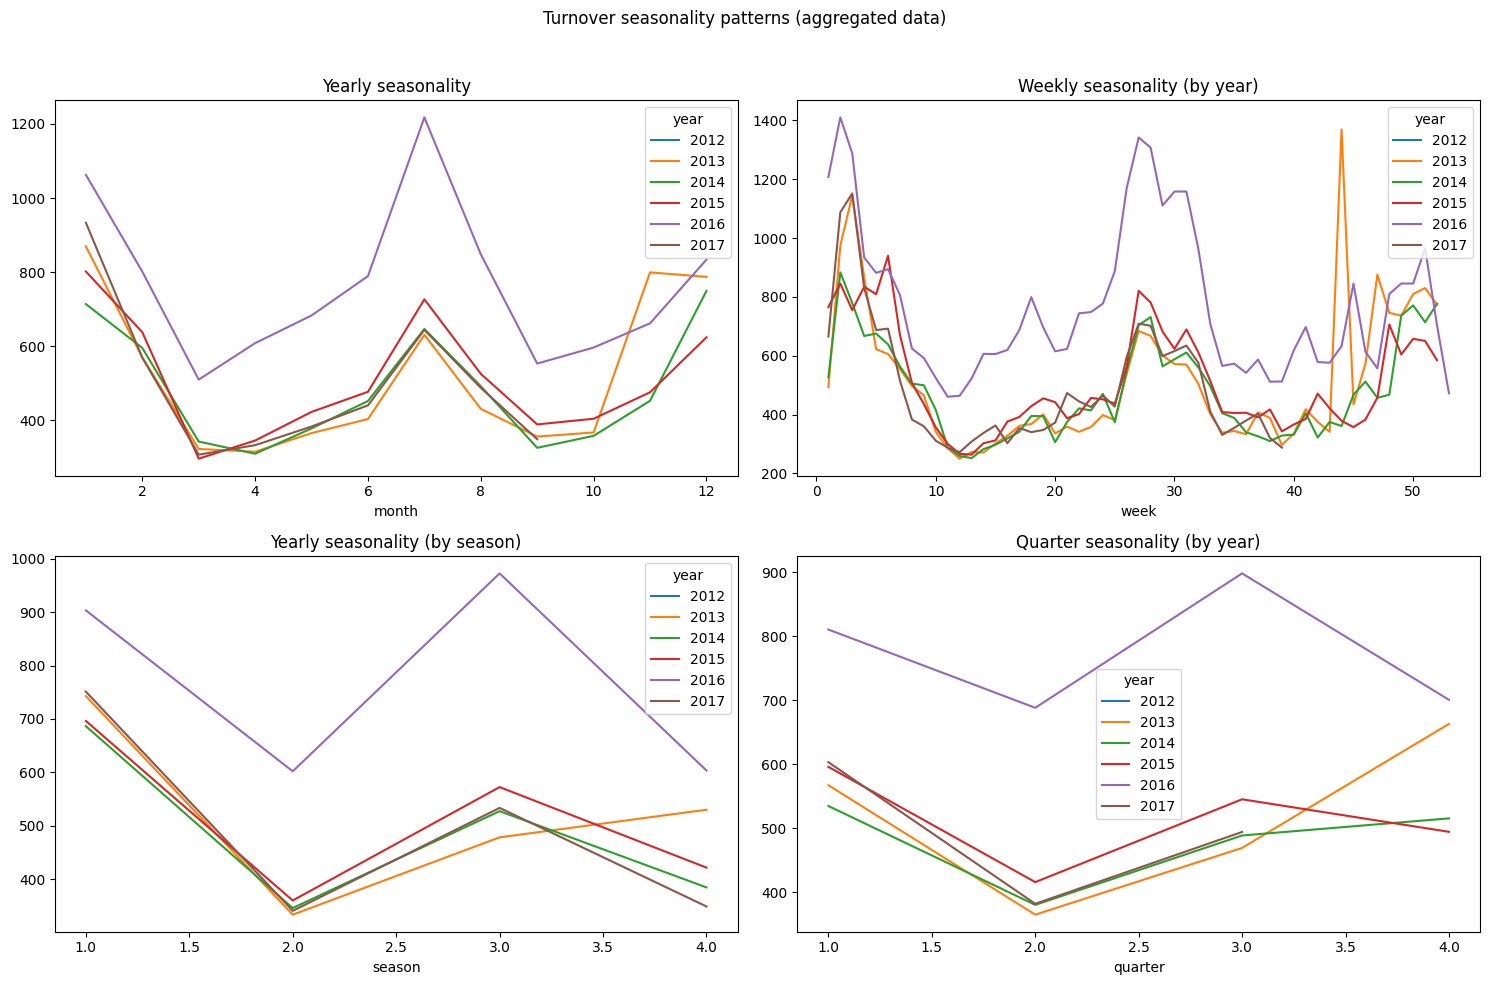

In [176]:
# make the plots
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
_ = pd.pivot_table(train_data, values='turnover', columns="year", index="month").plot(title="Yearly seasonality", ax=ax[0, 0])
_ = pd.pivot_table(train_data, values='turnover', columns='year', index='week').plot(title="Weekly seasonality (by year)", ax=ax[0, 1])
_ = pd.pivot_table(train_data, values='turnover', columns="year", index="season").plot(title="Yearly seasonality (by season)", ax=ax[1, 0])
_ = pd.pivot_table(train_data, values='turnover', columns='year', index='quarter').plot(title="Quarter seasonality (by year)", ax=ax[1, 1])
fig.suptitle('Turnover seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

#### Plot a sample of store turnover

In [177]:
def random_plot_turnover_by_store(data, row, col, department, nb_business_units=20, figsize=(20, 8)):
    """ Plot turnovers by a random subset of stores within a department"""

    fig, axs = plt.subplots(row, col, figsize=figsize)
     
    # get random business units
    business_unit_ids = data.but_num_business_unit.unique()
    business_unit_ids = random.sample(business_unit_ids.tolist(), nb_business_units+1)

    for i in range(1, row+1):
        for j in range(1, col+1):
            if (i*j) <=nb_business_units:

                bsns_id = business_unit_ids[i*j]
                business_unit_data = train_data.loc[(train_data["but_num_business_unit"]== bsns_id) & (train_data["dpt_num_department"]== department),
                                                    ["day_id", "turnover"]]

                axs[i-1,j-1].plot(business_unit_data.day_id, business_unit_data.turnover)
                axs[i-1, j-1].set_title('Business unit: {}'.format(bsns_id))
    
    fig.suptitle("Turnover over years for department: {}".format(department))
    fig.show()

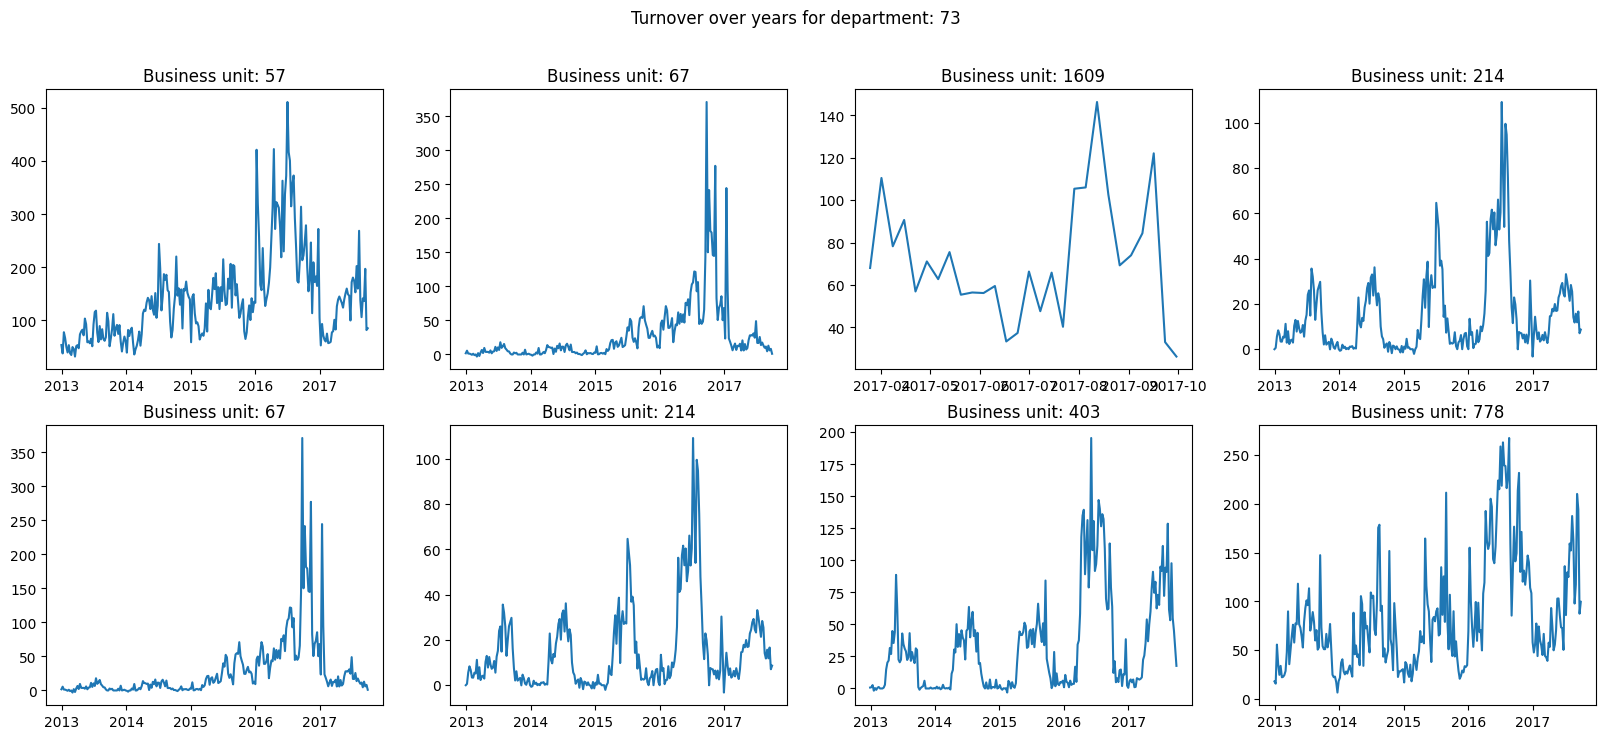

In [178]:
random_plot_turnover_by_store(data=train_data, row=2, col=4, department=73, nb_business_units=8)